<a href="https://colab.research.google.com/github/PedroJuiz/SupervisedLearning/blob/main/AIRBNB_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.display import HTML
HTML("\n".join(open('mioti_style.css', 'r').readlines()))

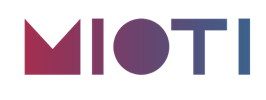
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S4: Predicción de precios AirBNB

## Objetivos

El objetivo de este challenge es predecir el precio de las viviendas de AirBnB Madrid a partir de alguna de sus características.

Este challenge utiliza un dataset real que no está pensado para aplicar técnicas de machine learning así que no esperes que las cosas funcionen bien a la primera 🤓.

## Configuración del entorno

In [ ]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt

## Dataset

Para este worksheet utilizaremos el dataset de airbnb Madrid.

In [ ]:
df = pd.read_csv('dataset_airbnb_madrid.csv')

In [ ]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7830063,https://www.airbnb.com/rooms/7830063,20170407214119,2017-04-08,Quiet room in Plaza Mayor,Room in magnificent property in the historic c...,"Based in the historic center of Madrid, to 1 m...",Room in magnificent property in the historic c...,none,"In the historic heart of Madrid, near the Plaz...",...,9.0,t,NaN,NaN,t,moderate,f,f,7,5.04
1,9898596,https://www.airbnb.com/rooms/9898596,20170407214119,2017-04-08,Homely apartment in the heart of Madrid,"Spacious apartment for up to 10 people, with a...",This spacious apartment is located in the cent...,"Spacious apartment for up to 10 people, with a...",none,The Living Santa Ana Apartments are located in...,...,9.0,t,NaN,NaN,t,moderate,f,f,1,4.39
2,15334645,https://www.airbnb.com/rooms/15334645,20170407214119,2017-04-08,Piso Muy Luminoso en pleno centro de Madrid,"Lugares de interés: Casa Lucio, Cine Doré, Cal...",Lo mejor es su ubicación en pleno centro de Ma...,"Lugares de interés: Casa Lucio, Cine Doré, Cal...",none,La zona de la Latina es un área cultural y un ...,...,9.0,t,NaN,NaN,t,strict,f,f,1,5.57
3,1307795,https://www.airbnb.com/rooms/1307795,20170407214119,2017-04-08,Rent room in the heart of Madrid,NaN,"Very nice room , whith private bath , in a bea...","Very nice room , whith private bath , in a bea...",none,NaN,...,10.0,t,NaN,NaN,f,strict,f,f,1,0.24
4,17410608,https://www.airbnb.com/rooms/17410608,20170407214119,2017-04-08,Luxury duplex penthouse in historic building,Amazing duplex penthouse in a historic buildin...,It is located in an emblematic building with e...,Amazing duplex penthouse in a historic buildin...,none,"""Madrid de los Austrias ""is a beautiful neighb...",...,10.0,t,NaN,NaN,f,strict,f,f,13,4.29


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335 entries, 0 to 13334
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13335 non-null  int64  
 1   listing_url                       13335 non-null  object 
 2   scrape_id                         13335 non-null  int64  
 3   last_scraped                      13335 non-null  object 
 4   name                              13335 non-null  object 
 5   summary                           12846 non-null  object 
 6   space                             9700 non-null   object 
 7   description                       13329 non-null  object 
 8   experiences_offered               13335 non-null  object 
 9   neighborhood_overview             8308 non-null   object 
 10  notes                             5037 non-null   object 
 11  transit                           8264 non-null   object 
 12  acce

Para simplificar el problema vamos a formular el problema del challenge de una manera más concreta:

Vamos a intentar predecir el precio:

In [ ]:
df_y = df['price']

A partir de 5 variables que a priori parecen relevantes para determinar el precio de un alojamiento: `['review_scores_rating', 'room_type', 'property_type', 'bedrooms', 'bathrooms']`

Como siempre, si tu quieres considerar otras variables adelante.

In [ ]:
df_X = df[['review_scores_rating', 'room_type', 'property_type', 'bedrooms', 'bathrooms' ]]

In [ ]:
df_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13335 entries, 0 to 13334
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   review_scores_rating  10417 non-null  float64
 1   room_type             13335 non-null  object 
 2   property_type         13335 non-null  object 
 3   bedrooms              13312 non-null  float64
 4   bathrooms             13285 non-null  float64
dtypes: float64(3), object(2)
memory usage: 521.0+ KB


## Preprocesamiento de datos

Como siempre, vamos a inspeccionar y estudiar cada variable por separado.

### Price

Es la variable de clase. Divide esta variable en 4 rangos (muy bajo, bajo, medio, alto, muy alto) que pienses que son razonables para estudiar esta variable. Como consejo, quizás puedes utilizar los percentiles para hacer esta división.

Antes de hacer esta división revisa que esta variable esté codificada como un número, si no lo está la tendrás que convertir previamente.

Una vez que tengas la variable transformada, conviértela a un array de numpy para trabajar.

In [ ]:
df_y.head()

0     $42.00
1    $135.00
2     $81.00
3     $43.00
4     $50.00
Name: price, dtype: object

In [ ]:
df_y = df_y.str.replace('$', '')
df_y = df_y.str.replace(',', '')
df_y = df_y.astype(float)

In [ ]:
df_y.head()

0     42.0
1    135.0
2     81.0
3     43.0
4     50.0
Name: price, dtype: float64

In [ ]:
#pd.qcut

def classifier(price):
    if price <= df_y.quantile(0.25):
        return 'Muy bajo'
    elif price <= df_y.quantile(0.5):
        return 'Bajo'
    elif price <= df_y.quantile(0.75):
        return 'Alto'
    else:
        return 'Muy alto'

df_y = df_y.apply(classifier)

In [ ]:
df_y.head()

0        Bajo
1    Muy alto
2    Muy alto
3        Bajo
4        Bajo
Name: price, dtype: object

### review_scores_rating

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [ ]:
df_X.review_scores_rating.head()

0     92.0
1     93.0
2     93.0
3     98.0
4    100.0
Name: review_scores_rating, dtype: float64

In [ ]:
df_X.review_scores_rating[df_X.review_scores_rating.isnull()] = df_X.review_scores_rating.mean()

In [ ]:
rating_max = np.max(df_X.review_scores_rating)
rating_min = np.min(df_X.review_scores_rating)
rango = rating_max - rating_min

print(f'La variable review_rating_score tiene un rango de {rango}\nMínimo: {rating_min}\nMáximo: {rating_max}')

La variable review_rating_score tiene un rango de 80.0
Mínimo: 20.0
Máximo: 100.0


In [ ]:
df_X.review_scores_rating.isnull().any()

False

### room_type

Esta variable parece un valor enumerado. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Si tiene muchos clases distintas piensa en reducirlas.

Una vez que esté bien crea variables ficticias a partir de esta.

In [ ]:
df_X.room_type.value_counts()

Entire home/apt    7935
Private room       5207
Shared room         193
Name: room_type, dtype: int64

In [ ]:
df_X.room_type.isnull().any()

False

In [ ]:
df_X = pd.get_dummies(df_X, columns=['room_type'])
df_X.head()

,review_scores_rating,property_type,bedrooms,bathrooms,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,92.0,House,1.0,2.0,0,1,0
1,93.0,Apartment,3.0,1.0,1,0,0
2,93.0,Apartment,1.0,1.0,1,0,0
3,98.0,Apartment,1.0,1.0,0,1,0
4,100.0,Apartment,2.0,1.5,1,0,0


### property_type

Esta variable parece un valor enumerado. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Si tiene muchos clases distintas piensa en reducirlas.

Una vez que esté bien crea variables ficticias a partir de esta.

In [ ]:
df_X.property_type.isnull().any()

False

In [ ]:
df_X.property_type.value_counts()

Apartment             10974
House                  1001
Condominium             346
Bed & Breakfast         339
Loft                    285
Other                   220
Dorm                     44
Guesthouse               39
Chalet                   24
Hostel                   16
Serviced apartment       13
Townhouse                 9
Boutique hotel            6
Villa                     4
Guest suite               3
Casa particular           3
Earth House               3
Camper/RV                 2
Timeshare                 1
Bungalow                  1
Tent                      1
Boat                      1
Name: property_type, dtype: int64

In [ ]:
def agrupar_clases(x):
    if x in ['Apartment', 'House', 'Condominium', 'Bed & Breakfast', 'Loft']:
        return 'Residencial'
    elif x in ['Dorm', 'Guesthouse', 'Chalet', 'Hostel', 'Serviced apartment', 'Boutique hotel']:
        return 'Alojamiento'
    else:
        return 'Otro'

df_X.property_type = df_X.property_type.apply(agrupar_clases)

In [ ]:
df_X.property_type.value_counts()

Residencial    12945
Otro             248
Alojamiento      142
Name: property_type, dtype: int64

In [ ]:
df_X = pd.get_dummies(df_X, columns=['property_type'])
df_X.head()

,review_scores_rating,bedrooms,bathrooms,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Alojamiento,property_type_Otro,property_type_Residencial
0,92.0,1.0,2.0,0,1,0,0,0,1
1,93.0,3.0,1.0,1,0,0,0,0,1
2,93.0,1.0,1.0,1,0,0,0,0,1
3,98.0,1.0,1.0,0,1,0,0,0,1
4,100.0,2.0,1.5,1,0,0,0,0,1


### bedrooms

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [ ]:
df_X.bedrooms.isnull().any()

True

In [ ]:
df_X.bedrooms[df_X.bedrooms.isnull()] = df_X.bedrooms.mean()

In [ ]:
df_X.bedrooms.isnull().any()

False

In [ ]:
bed_max = np.max(df_X.bedrooms)
bed_min = np.min(df_X.bedrooms)
rango_bed = bed_max - bed_min

print(f'La variable bedrooms tiene un rango de {rango_bed}\nMínimo: {bed_min}\nMáximo: {bed_max}')

La variable bedrooms tiene un rango de 10.0
Mínimo: 0.0
Máximo: 10.0


### bathrooms

Esta variable parece un número. Revisa:

* Si tiene nulos o no. Si los tiene trátalos adecuadamente.
* Revisa el rango de la variable.

In [ ]:
df_X.bathrooms.isnull().any()

True

In [ ]:
df_X.bathrooms[df_X.bathrooms.isnull()] = df_X.bathrooms.mean()

In [ ]:
df_X.bathrooms.isnull().any()

False

In [ ]:
bath_max = np.max(df_X.bathrooms)
bath_min = np.min(df_X.bathrooms)
rango_bath = bath_max - bath_min

print(f'La variable bedrooms tiene un rango de {rango_bath}\nMínimo: {bath_min}\nMáximo: {bath_max}')

La variable bedrooms tiene un rango de 8.0
Mínimo: 0.0
Máximo: 8.0


### Chequeos finales y conversión a numpy

Una vez que hemos revisado cada variable hacemos algunas comprobaciones finales:

In [ ]:
df_X.isnull().any()

review_scores_rating         False
bedrooms                     False
bathrooms                    False
room_type_Entire home/apt    False
room_type_Private room       False
room_type_Shared room        False
property_type_Alojamiento    False
property_type_Otro           False
property_type_Residencial    False
dtype: bool

In [ ]:
df_X.tail()

,review_scores_rating,bedrooms,bathrooms,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,property_type_Alojamiento,property_type_Otro,property_type_Residencial
13330,97.00000,2.0,1.0,0,1,0,0,0,1
13331,100.00000,1.0,1.0,0,1,0,0,0,1
13332,91.62062,1.0,1.0,0,1,0,0,0,1
13333,100.00000,1.0,1.0,1,0,0,0,0,1
13334,91.62062,1.0,1.0,0,1,0,0,0,1


Y convertimos a un array de `numpy`:

In [ ]:
dataset_X = np.array(df_X)

In [ ]:
dataset_X.shape

(13335, 9)

In [ ]:
dataset_X

array([[ 92.        ,   1.        ,   2.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 93.        ,   3.        ,   1.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 93.        ,   1.        ,   1.        , ...,   0.        ,
          0.        ,   1.        ],
       ...,
       [ 91.62062014,   1.        ,   1.        , ...,   0.        ,
          0.        ,   1.        ],
       [100.        ,   1.        ,   1.        , ...,   0.        ,
          0.        ,   1.        ],
       [ 91.62062014,   1.        ,   1.        , ...,   0.        ,
          0.        ,   1.        ]])

## Conjunto de entrenamiento y test

Crea un conjunto de entrenamiento y test con una proporción del 30%.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_X, df_y, test_size=.3, random_state=123)

## Entrenamiento y clasificación

Utiliza un RandomForest como algoritmo de clasificación y entrena el modelo.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=123)

In [ ]:
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

## Evalua el modelo

Calcula score, ROC y matriz de confusión

In [ ]:
y_hat = random_forest.predict(X_test)

In [ ]:
random_forest.score(X_test, y_test)

0.5816045988502875

Calculamos diferentes métricas para evaluar al modelo:

In [ ]:
accu = accuracy_score(y_test, y_hat)
prec = precision_score(y_test, y_hat, average='weighted')
recall = recall_score(y_test, y_hat, average='weighted')
f1 = f1_score(y_test, y_hat, average='weighted')

print(f'Accuracy: {accu}\nPrecision_score: {prec}\nRecall_score: {recall}\nF1_score: {f1}')

Accuracy: 0.5816045988502875
Precision_score: 0.5611449908426588
Recall_score: 0.5816045988502875
F1_score: 0.5344433047957241


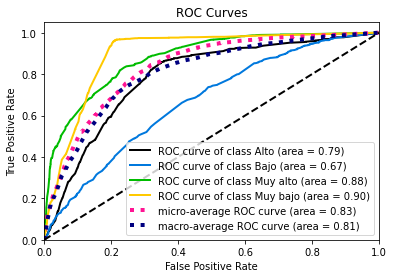

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc(y_test, random_forest.predict_proba(X_test))
plt.show()

In [ ]:
confusion_matrix(y_test, y_hat)

array([[628,  74, 266,  73],
       [303, 122, 109, 471],
       [247,  17, 632,  47],
       [ 23,  37,   7, 945]], dtype=int64)

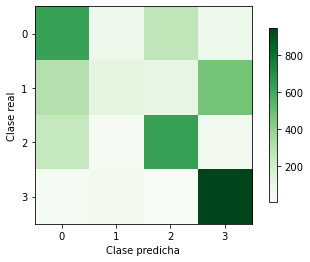

In [ ]:
plt.imshow(confusion_matrix(y_test, y_hat), cmap="Greens")
plt.colorbar(shrink=0.8)
plt.xticks(range(4))
plt.yticks(range(4))
plt.xlabel("Clase predicha")
plt.ylabel("Clase real");

### Preguntas

* ¿Consideras que los resultados son buenos o malos?

Debido a los resultados que suelen obtenerse en estos modelos, se puede decir que basándonos en las métricas de evaluación el modelo ofrece buenos resultados.
* Qué podemos hacer para mejorarlo?

Podría utilizarse el método grid search con la finalidad de encontrar los hiperparámetros óptimos para nuestro y ver si mejora los resultados.

## Método Grid Search  

In [ ]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state=123)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros y puntuaciones
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimir los mejores parámetros y puntuaciones
print(f'Best parameters: {best_params}')
print(f'Best accuracy: {best_score}')

# Obtener la precisión del modelo optimizado
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy: 0.5747787917982032
Test accuracy: 0.5833541614596351


Observamos que el modelo con los parametros optimizados mejora minimamente los resultados.